In [1]:
#could explore more to figure out what dtype is and where it is suppose to come from

In [57]:
import pickle
with open('DMTS_8odors_5acids_allMice_raw_PerceptualData_forRick_122319.pkl', 'rb') as f:
        data = pickle.load(f)

In [3]:
import pandas as pd
len(data["data"][0]["odor_1st"].unique())
data_values = pd.concat(data["data"])
len(data_values["odor_2nd"].unique() & data_values["odor_1st"].unique() )

24

In [4]:
import keras
from mle_1g_test import build_model
import numpy as np
import matplotlib.pyplot as plt
import psiz
import tensorflow as tf
import plotly.graph_objects as go
import plotly

In [5]:
#reconstructed_model = psiz.models.load_model("saving_whole_model")

In [6]:
kinds_of_models = pickle.load(open("kinds_of_models.p", "rb"))

In [7]:
kinds_of_models

{'rho__beta_trainable': {'rho_trainable': True,
  'beta_trainable': True,
  'gamma_trainable': False,
  'tau_trainable': False},
 'beta_trainable': {'rho_trainable': False,
  'beta_trainable': True,
  'gamma_trainable': False,
  'tau_trainable': False},
 'all_trainable': {'rho_trainable': True,
  'beta_trainable': True,
  'gamma_trainable': True,
  'tau_trainable': True}}

In [8]:
models = {kind_of_model: build_model(24, 2, **kwargs) for kind_of_model, kwargs in kinds_of_models.items()}

In [9]:
models

{'rho__beta_trainable': <psiz.models.rate.Rate at 0x7f6e6b70f370>,
 'beta_trainable': <psiz.models.rate.Rate at 0x7f6e68697a60>,
 'all_trainable': <psiz.models.rate.Rate at 0x7f6e686a3f40>}

In [10]:
for kind_of_model in models:
    models[kind_of_model].load_weights("weights_%s" % kind_of_model)

In [11]:
#1. Does not load embeddings but the line works
#This doesn't do much because embedding is already set to this, the models already know the dimensions
#models["all_trainable"].stimuli.embedding = tf.keras.layers.Embedding(25, 2, mask_zero=True)
#Example: rho_beta_true.stimuli.embedding = tf.keras.layers.Embedding(n_stimuli+1, n_dim, mask_zero=True)

In [12]:
#2. Does not work
#This approach does not work because it does not recognize "mask_zero"
#models["all_trainable"].stimuli.embedding(tf.keras.layers.Embedding, 25, 2, mask_zero=True)
#Example : #rho_beta_true.stimuli.embedding(tf.keras.layers.Embedding, n_stimuli+1, n_dim, mask_zero=True)

In [13]:
#3. Works but gives the same kind of error as number 4
#This is the error I get with this approach "AttributeError: 'str' object has no attribute 'base_dtype'"" but this approach does work as well
#models["all_trainable"].stimuli.embedding(tf.keras.layers.Embedding(25+1, 2, mask_zero=True))
# Example: rho_beta_true.stimuli.embedding(tf.keras.layers.Embedding(n_stimuli+1, n_dim, mask_zero=True))

In [14]:
models["all_trainable"].weights

[<tf.Variable 'beta:0' shape=() dtype=float32, numpy=1.0005667>,
 <tf.Variable 'gamma:0' shape=() dtype=float32, numpy=0.30184758>,
 <tf.Variable 'rho:0' shape=() dtype=float32, numpy=1.002886>,
 <tf.Variable 'tau:0' shape=() dtype=float32, numpy=1.2697594>,
 <tf.Variable 'lower:0' shape=() dtype=float32, numpy=0.014728185>,
 <tf.Variable 'upper:0' shape=() dtype=float32, numpy=0.7523214>,
 <tf.Variable 'midpoint:0' shape=() dtype=float32, numpy=0.50458354>,
 <tf.Variable 'rate:0' shape=() dtype=float32, numpy=3.7058692>]

In [15]:
#models["all_trainable"].stimuli.embedding(psiz.psiz.keras.layers.embeddings.EmbeddingLogNormalDiag)

In [16]:
# This "For user-defined classes which inherit from tf.keras.Model, Layer instances must be assigned to object attributes, typically in the constructor." 
# is why I had to pass the class in the constructor
models["all_trainable"].stimuli.embedding(psiz.psiz.keras.layers.embeddings)

AttributeError: module 'psiz.keras.layers.embeddings' has no attribute 'dtype'

In [17]:
models["beta_trainable"].stimuli.embedding(psiz.psiz.keras.layers.embeddings)

AttributeError: module 'psiz.keras.layers.embeddings' has no attribute 'dtype'

In [18]:
models["rho__beta_trainable"].stimuli.embedding(psiz.psiz.keras.layers.embeddings)

AttributeError: module 'psiz.keras.layers.embeddings' has no attribute 'dtype'

In [19]:
coords_dictionary = {
    'rho_beta_true_coords' : models["rho__beta_trainable"].stimuli.embeddings.numpy()[0],
    'beta_true_coords' : models["beta_trainable"].stimuli.embeddings.numpy()[0],
    'all_true_coords' : models["all_trainable"].stimuli.embeddings.numpy()[0]
}

In [20]:
import plotly.express as px

In [21]:
data["odorNames"]

['CinAld',
 'EB',
 '2MBAcd',
 '22DMBAcd',
 'CPAcd',
 '2Hep',
 'IBAcd',
 'IVAcd',
 'CinAld_CPAcd',
 'CinAld_2Hep',
 'CinAld_IBAcd',
 'CinAld_IVAcd',
 'EB_CPAcd',
 'EB_2Hep',
 'EB_IBAcd',
 'EB_IVAcd',
 '2MBAcd_CPAcd',
 '2MBAcd_2Hep',
 '2MBAcd_IBAcd',
 '2MBAcd_IVAcd',
 '22DMBAcd_CPAcd',
 '22DMBAcd_2Hep',
 '22DMBAcd_IBAcd',
 '22DMBAcd_IVAcd']

In [25]:
def make_df(**all_data):
    df = pd.DataFrame()
    for every_coord in all_data.values():
        single_dataframe = pd.DataFrame(every_coord[1:,:], index=data["odorNames"], columns = ["x","y"])
        df = pd.concat([df, single_dataframe])
    df["colors"] = "black"
    df["name"] = df.index
    return df

In [100]:
def update_color(half_one, half_two, mixture):
    odor_one_index = data["odorNames"].index(half_one)
    odor_two_index = data["odorNames"].index(half_two)
    mixture_index = data["odorNames"].index(mixture)
    mix_list = ["black"] * len(range(0, odor_one_index)) + ["red"] + ["black"] * len(range(odor_one_index+1, odor_two_index)) + ["blue"] + ["black"] * len(range(odor_two_index+1, mixture_index)) + ["purple"] + ["black"] * len(range(mixture_index+1,len(data["odorNames"])))
    return mix_list

In [120]:
def create_buttons(odor_mixture):
    split_mixture = odor_mixture.split("_")
    update_color(split_mixture[0], split_mixture[1], odor_mixture)
    button = dict(
        label = odor_mixture,
        method = "restyle",
        args=[{
            "marker.color" : [update_color(split_mixture[0], split_mixture[1], odor_mixture)]
        }]
    )
    return button

In [136]:
def color_plots(**data_coordinates):
    all_data = make_df(**data_coordinates)
    # come back to all_data shape being 72, but each coords is a set of 25
    n_coords = len(list(data_coordinates.values())[0])

    plot = go.Figure(
        data=[
            go.Scatter(
                x=all_data.iloc[i : i + n_coords, 0],
                y=all_data.iloc[i : i + n_coords, 1],
                mode="markers",
                marker=dict(color=all_data.iloc[i : i + 24]["colors"]),
            )
            for i in [0, 24, 48]
        ]
    )

    assign_name = 0
    for trace in plot.data:
        if assign_name != len(data_coordinates):
            trace.name = list(data_coordinates)[assign_name]
        assign_name += 1

    plot.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                showactive=True,
                active=True,
                buttons=list(
                    [
                        create_buttons(odor) for odor in data["odorNames"] if "_" in odor
                    ]
                ),
            )
        ]
    )
    plot.show()

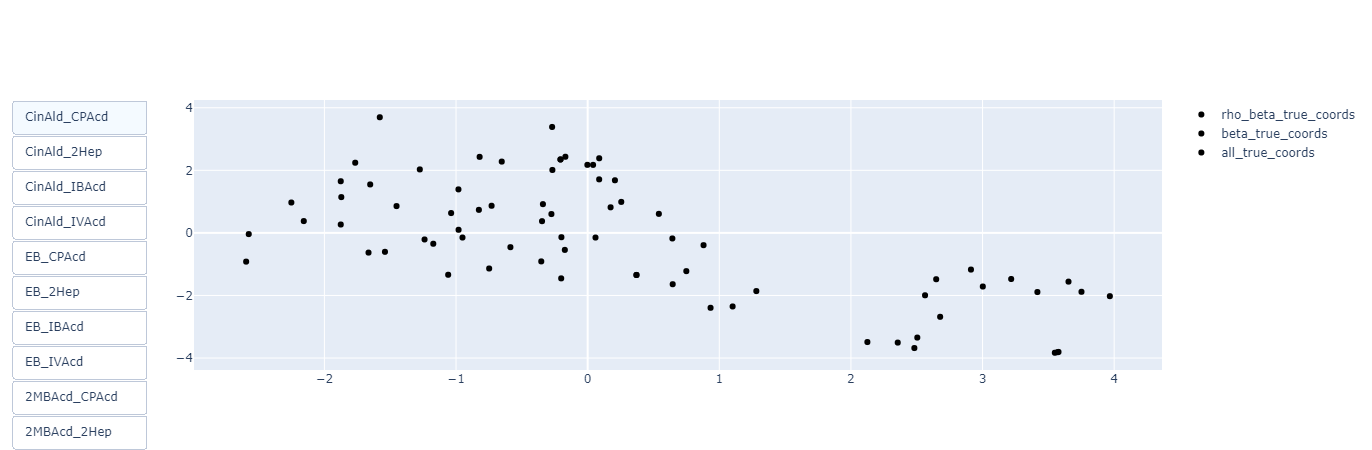

In [137]:
color_plots(**coords_dictionary)